In [310]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import dill as pickle

from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.utils import ActiveSubspace

from stg_energy.common import col, get_labels_8pt, svg
from stg_energy.fig3_amortize_energy.helper_functions import (
    active_subspace,
    get_gradient,
)
import stg_energy.fig3_amortize_energy.viz as viz

# Figure 3

In [311]:
pd.options.display.max_columns = 999

In [312]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_REG_A1 = "../svg/panel_reg_a1.svg"
PANEL_REG_A2 = "../svg/panel_reg_a2.svg"
PANEL_REG_B = "../svg/panel_reg_b.svg"
PANEL_REG_C = "../svg/panel_reg_c.svg"
PANEL_REG_D1 = "../svg/panel_reg_d1.svg"
PANEL_REG_D2 = "../svg/panel_reg_d2.svg"
PANEL_REG_D3 = "../svg/panel_reg_d3.svg"
PANEL_REG_D4 = "../svg/panel_reg_d4.svg"
PANEL_REG_E = "../svg/panel_reg_e.svg"
PANEL_REG_F = "../svg/panel_reg_f.svg"
PANEL_REG_F_alt = "../svg/panel_reg_f_alt.svg"
PANEL_REG_G = "../svg/panel_reg_g.svg"
PANEL_REG_H = "../svg/panel_reg_h.svg"
PANEL_REG_G2 = "../svg/panel_reg_g2.svg"
PANEL_REG_H2 = "../svg/panel_reg_h2.svg"
PANEL_quality_of_approx_NN = "../svg/panel_quality_of_approx_NN.svg"
PANEL_NN_REG = "../../fig4_sensitivity/svg/panel_nn_reg.svg"

### Load experimental data

In [314]:
prior_11 = create_prior()

In [315]:
theta = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl")
x = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl")
seeds = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy")

theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [316]:
energies = x['energies']
summed_energies = np.sum(energies.to_numpy(), axis=1)

### Simulate the 55,000 samples and keep track of the energy consumption of each trace

In [317]:
def simulator(p_with_s):
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0],
        seed=int(p_with_s[-1]),
        track_energy=True,
        track_currents=True
    )
    all_energies = energy_of_membrane(out_target)
    synaptic_energies = energy_of_synapse(out_target)

    summed_energy_each_current = np.sum(all_energies, axis=2)
    summed_energy_synapses = np.sum(synaptic_energies, axis=1)
    summed_energy_total = np.sum(all_energies) + np.sum(synaptic_energies)
    fraction_of_each_current = summed_energy_each_current / summed_energy_total
    fraction_of_synapse = summed_energy_synapses / summed_energy_total
    return (fraction_of_each_current, fraction_of_synapse)

In [318]:
params_with_seeds = np.concatenate((theta_np[:10], seeds[:10][None, ].T), axis=1)
simulation_outputs = list(map(simulator, params_with_seeds))

In [319]:
all_e_cur = []
all_e_syn = []
for so in simulation_outputs:
    e_cur, e_syn = so
    all_e_cur.append(e_cur)
    all_e_syn.append(e_syn)

all_e_cur = np.asarray(all_e_cur)
all_e_syn = np.asarray(all_e_syn)
fractions = np.mean(all_e_cur, axis=0)
synapse_fractions = np.mean(all_e_syn, axis=0)

In [320]:
current_fractions = fractions.T.flatten()
all_fractions = np.concatenate((current_fractions, synapse_fractions))
all_fractions /= np.linalg.norm(all_fractions)
# np.savez('../../results/fig3_fraction_consumed_currents.npz', all_fractions=all_fractions)

In [321]:
# all_fractions = np.load('../../results/fig3_fraction_consumed_currents.npz')['all_fractions']

# Panel 0: Fit regression net

In [322]:
with open('../../../results/trained_neural_nets/inference/posterior_11deg.pickle', 'rb') as handle:
    posterior = pickle.load(handle)

In [323]:
xo = np.load('../../../results/experimental_data/xo_11deg.npy')

In [324]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [325]:
print(energies_tt.shape)

torch.Size([35939, 3])


In [326]:
num_test = 1000

theta_test = theta_np[:num_test]
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [327]:
train_energy_ABPD = torch.as_tensor(torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32)
test_energy_ABPD = torch.as_tensor(torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32)

In [328]:
sensitivity = ActiveSubspace(posterior.set_default_x(xo))

In [329]:
converged_nn = sensitivity.add_property(theta_train, train_energy_ABPD, hidden_features=20, num_blocks=1).train(max_num_epochs=2)

In [330]:
e_vals, e_vecs = sensitivity.find_active()

In [331]:
predictions = converged_nn(torch.as_tensor(theta_test)).detach()

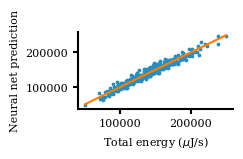

In [332]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD[:300]
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("Neural net prediction")
#     plt.savefig(PANEL_quality_of_approx_NN, facecolor='None', transparent=False)

In [333]:
unnorm_y = predictions[:300]
mse = torch.mean(torch.abs(unnorm_x - unnorm_y)**2)
print("mean squared error: ", mse)

mean squared error:  tensor(60711888.)


### Plot correlation between parameter and energy

In [334]:
summed_energies / 40000

array([3.57224328, 3.86716971, 3.2331312 , ..., 4.09939826, 3.33829115,
       5.68127033])

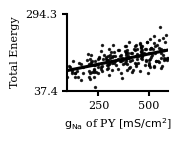

In [335]:
PY_Na = theta_np[:, 16]
num_scatter = 200

summed_energies_joule = summed_energies / 1000
df = pd.DataFrame(data=[PY_Na[:num_scatter], summed_energies_joule[:num_scatter]], index=["PY_Na", "total_energy"])

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.3,1.0))
    sns.regplot(x=PY_Na[:num_scatter], y=summed_energies_joule[:num_scatter], scatter_kws={"s":2}, ci=None, color='k');
    ax.set_xlabel('$\mathrm{g}_{\mathrm{Na}}$ of PY [$\mathrm{mS}/\mathrm{cm}^2$]')
    ax.set_ylabel('Total Energy')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.xaxis.set_label_coords(0.5, -0.35)
    ax.set_ylim([np.min(summed_energies_joule), np.max(summed_energies_joule)])
    ax.set_yticks([np.min(summed_energies_joule), np.max(summed_energies_joule)])
#     ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_REG_A1, facecolor='None', transparent=False)

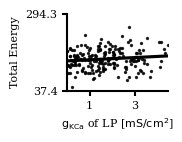

In [336]:
ABPD_Na = theta_np[:, 20]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.3,1))
    sns.regplot(x=ABPD_Na[:num_scatter], y=summed_energies_joule[:num_scatter], scatter_kws={"s":2}, ci=None, color='k');
    ax.set_xlabel('$\mathrm{g}_{\mathrm{KCa}}$ of LP [$\mathrm{mS}/\mathrm{cm}^2$]')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([np.min(summed_energies_joule), np.max(summed_energies_joule)])
    ax.set_ylabel('Total Energy')
    ax.set_yticks([np.min(summed_energies_joule), np.max(summed_energies_joule)])
#     ax.set_yticklabels(["min", "max"])
#     ax.set_yticks([])
    ax.set_xticks([1, 3])
    plt.savefig(PANEL_REG_A2, facecolor='None', transparent=False)

### Sketch of active subspace

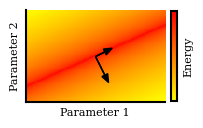

In [337]:
from matplotlib.colors import Normalize
import matplotlib.cm

figureratio = 1.5
figuresize = 1.3

vec1 = np.linspace(-3,3,int(figureratio * 100))
vec2 = np.linspace(-3,3,100)

X,Y = np.meshgrid(vec1, vec2)
dist = np.abs(X + 1.5*Y)

m_e = [0.0, -.1]
s_e = [6., 0.7]
m_e_2 = [1.1, 1.7]
s_e_2 = [1.5, 6.]
dists_e_1 = s_e[0]*(X-m_e[0])**2 + s_e[1]*(Y-m_e[1])**2
dists_e_2 = s_e_2[0]*(X-m_e_2[0])**2 + s_e_2[1]*(Y-m_e_2[1])**2
dists_e = np.minimum(dists_e_1, dists_e_2)
allowed_dist = 5.0
thr_dists_e = dists_e < allowed_dist
inds = np.where(np.abs(dists_e - allowed_dist) < 0.5)
inds = np.asarray(inds).T
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(figureratio*figuresize,figuresize))\

    image_to_plot = -np.sqrt(dist)

    im = ax.imshow(image_to_plot, cmap='autumn_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Parameter 1")
    ax.set_ylabel("Parameter 2")

    cbar = plt.colorbar(im, aspect=15,fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label('Energy', labelpad=5)
    ax.arrow(75, 50, 10, -5, head_width=7, head_length=9, facecolor='k')
    ax.arrow(75, 50, 10, 20, head_width=7, head_length=9, facecolor='k')
#     plt.savefig(PANEL_REG_B, facecolor='None', transparent=False)

### Plot all 31D eigenvalues
It seems that energy lies largely in a 1D subspace. As we will show below, within theis subspace, it is possible to optimize both the energy/spike and the number of spikes.

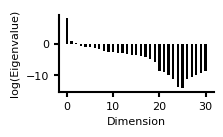

In [339]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(torch.log(torch.abs(torch.flip(e_vals, dims=(0,)))), figsize=(2.0, 1.0), color='k')
    plt.savefig(PANEL_REG_C, facecolor='None', transparent=False)
    plt.show()

In [97]:
print("Ratio of first two eigenvalues:  ", e_vals[-1] / e_vals[-2])

Ratio of first two eigenvalues:   tensor(710.4860)


### Plot first eigenvector

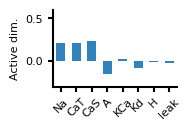

In [98]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[0:8, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='Active dim.', plot_labels=True, color="#3182bd")
    plt.savefig(PANEL_REG_D1, facecolor='None', transparent=False)
    plt.show()

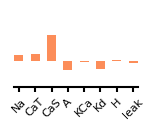

In [99]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[8:16, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel=None, plot_labels=False, color="#fc8d59")
    plt.savefig(PANEL_REG_D2, facecolor='None', transparent=False)
    plt.show()

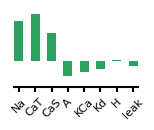

In [100]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[16:24, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel=None, plot_labels=False, color="#2ca25f")
    plt.savefig(PANEL_REG_D3, facecolor='None', transparent=False)
    plt.show()

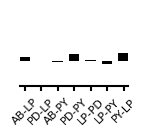

In [101]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(e_vecs[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel='', color="k")
    plt.savefig(PANEL_REG_D4, facecolor='None', transparent=False)
    plt.show()

In [102]:
# with mpl.rc_context(fname="../../.matplotlibrc"):
#     viz.py_sensitivity_bars(e_vecs[16:24, -1:].T, ylim=[-0.3, 0.6], figsize=(2.8, 1.0), ylabel='PY neuron', color="#2ca25f")
#     plt.savefig(PANEL_REG_E, facecolor='None', transparent=False)
#     plt.show()

## Which parameters affect energy, which parameters influence energy?

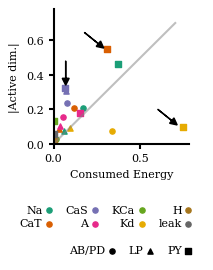

In [278]:
eigenvector = e_vecs[:, -1].numpy()

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.75, 1.75))

    markers = ['o', '^', 's']
    cols_hex = [
        "#1b9e77",
        "#d95f02",
        "#7570b3",
        "#e7298a",
        "#66a61e",
        "#e6ab02",
        "#a6761d",
        "#666666",
    ]
    labels = ['Na', 'CaT', 'CaS', 'A', 'KCa', 'Kd', 'H', 'leak']
    labels2 = ['AB/PD', 'LP', 'PY']
    ims = []
#     for synapse in range(7):
#         im = ax.scatter(
#             all_fractions[24+synapse],
#             np.abs(eigenvector)[24+synapse],
#             c='k',
#             marker='o',
#             s=10
#         )
#     ims.append(im)
    for neuron in range(3):
        for channel, c in enumerate(cols_hex):
            im = ax.scatter(
                    all_fractions[channel+neuron*8], 
                    np.abs(eigenvector)[channel+neuron*8], 
                    c=c, 
                    marker=markers[neuron], 
                    s=14
                )
            if neuron == 0:
                ims.append(im)

    # Dummy scatter outside of limits for the legend:
    ims2 = []
    ims2.append(ax.scatter([10.],[10.], c='k', marker='o', s=14))
    ims2.append(ax.scatter([10.],[10.], c='k', marker='^', s=14))
    ims2.append(ax.scatter([10.],[10.], c='k', marker='s', s=14))

    leg1 = ax.legend(ims, labels, bbox_to_anchor=(1.05, -0.88, 0.1, 0.5), labelspacing=0.3, columnspacing=0.5, markerfirst=False, handletextpad=-0.4, ncol=4)
    leg2 = ax.legend(ims2, labels2, bbox_to_anchor=(1.05, -1.18, 0.1, 0.5), labelspacing=0.3, columnspacing=0.5, markerfirst=False, handletextpad=-0.4, ncol=3)
    ax.add_artist(leg1)
#     import itertools
#     def flip(items, ncol):
#         return itertools.chain(*[items[i::ncol] for i in range(ncol)])
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(flip(handles, 2), flip(labels, 2), bbox_to_anchor=(1.1, -0.9, 0.1, 0.5), labelspacing=0.3, columnspacing=0.5, markerfirst=False, handletextpad=-0.4, ncol=4)

    ax.arrow(0.6, 0.2, 0.08, -0.065, head_width=0.04, head_length=0.04, facecolor='k')
    ax.arrow(0.178, 0.645, 0.08, -0.065, head_width=0.04, head_length=0.04, facecolor='k')
    ax.arrow(0.07, 0.48, 0.0, -0.1, head_width=0.04, head_length=0.04, facecolor='k')

    ax.plot([0.0, 0.7], [0.0, 0.7], color='grey', alpha=0.5)
    ax.set_xlim([0.0, 0.78])
    ax.set_ylim([0.0, 0.78])

    ax.set_xlabel('Consumed Energy')
    ax.set_ylabel('|Active dim.|')
    plt.savefig(PANEL_REG_F_alt, facecolor='None', transparent=False)

### Project into 1D plane

In [185]:
# num_scatter = 1000

# projection_mat = e_vecs[:, :1]
# train_params_norm_tt = torch.as_tensor(theta_train)[:num_scatter]
# all_train_params_norm_tt = torch.as_tensor(theta_train)
# projected = torch.mm(train_params_norm_tt, projection_mat)[:num_scatter]
# all_projected = torch.mm(all_train_params_norm_tt, projection_mat)

In [186]:
projected = sensitivity.project(theta_train, num_dimensions=1)

In [187]:
minimal_dim0_set = projected[torch.argmin(projected[:, 0])]
maximal_dim0_set = projected[torch.argmax(projected[:, 0])]

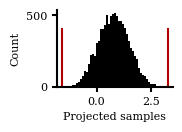

In [283]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    _ = ax.hist(projected[:10000].T, bins=50, facecolor='k')
    ax.axvline(minimal_dim0_set, c="#b30000", ymin=0, ymax=0.75)
    ax.axvline(maximal_dim0_set, c="#b30000", ymin=0, ymax=0.75)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Projected samples")
    ax.set_ylabel("Count")
    plt.savefig(PANEL_REG_F, facecolor='None', transparent=False)

### Simulate the most extreme cases and show the PY neuron

In [284]:
min_of_energy = torch.min(torch.sum(energies_tt, dim=1)).item() / 1000
max_of_energy = torch.max(torch.sum(energies_tt, dim=1)).item() / 1000

In [285]:
theta_min = theta_train[int(torch.argmin(projected[:, 0]))].unsqueeze(0)
theta_max = theta_train[int(torch.argmax(projected[:, 0]))].unsqueeze(0)

theta_min = pd.DataFrame(theta_min.numpy(), columns=theta.columns)
theta_max = pd.DataFrame(theta_max.numpy(), columns=theta.columns)

In [286]:
simulation_output_dim0_min = simulate(theta_min.loc[0], seed=0, track_energy=True, track_currents=True)
simulation_output_dim0_max = simulate(theta_max.loc[0], seed=0, track_energy=True, track_currents=True)

In [287]:
time_vec = np.arange(0, 11000, 0.025)

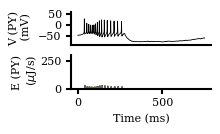

In [288]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_dim0_min,
        time_vec,
        (1.8, 1.0),
        ["k", "k", "k"],
        time_len=30000,
        offset=85000,
    )
    plt.savefig(PANEL_REG_G, facecolor='None', transparent=False)
# 18 spikes

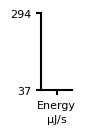

In [296]:
summstats = summary_stats(simulation_output_dim0_min, stats_customization={'energies': True})
energies_PY_sim = np.sum(summstats['energies'].to_numpy()) / 1000

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.4, 1.0))
    height_energy = (energies_PY_sim - min_of_energy) / (max_of_energy - min_of_energy)
    ax.bar(np.arange(0, 1), [height_energy], width=0.13, facecolor='k')
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.2, 0.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Energy\n$\mu$J/s'])
    ax.set_yticklabels([round(min_of_energy), round(max_of_energy)])
    plt.savefig(PANEL_REG_G2, facecolor='None', transparent=False)
    plt.show()

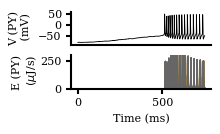

In [290]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_dim0_max,
        time_vec,
        (1.8, 1.0),
        ["k", "k", "k"],
        time_len=30000,
        offset=50000,
    )
    plt.savefig(PANEL_REG_H, facecolor='None', transparent=False)
# 29 spikes

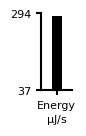

In [297]:
summstats = summary_stats(simulation_output_dim0_max, stats_customization={'energies': True})
energies_PY_sim = np.sum(summstats['energies'].to_numpy()) / 1000

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.4, 1.0))
    height_energy = (energies_PY_sim - min_of_energy) / (max_of_energy - min_of_energy)

    ax.bar(np.arange(0, 1), [height_energy], width=0.13, facecolor='k')
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.2, 0.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Energy\n$\mu$J/s'])
    ax.set_yticklabels([round(min_of_energy), round(max_of_energy)])
    plt.savefig(PANEL_REG_H2, facecolor='None', transparent=False)
    plt.show()

In [298]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [308]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "10.0cm",

    Panel(
          SVG(PANEL_REG_A1).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_REG_A2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(30.2*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_NN_REG).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -4.0*factor_svg, -4.5*factor_svg, **kwargs_text),
    ).move(69*factor_svg, 7*factor_svg),

    Panel(
          SVG(PANEL_REG_B).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
          Text("inactive", 15.0*factor_svg, 7.0*factor_svg, **kwargs_text8pt),
          Text("active", 11.0*factor_svg, 13.5*factor_svg, **kwargs_text8pt),
    ).move(107*factor_svg, 0*factor_svg),
    Panel(
          SVG(PANEL_REG_D1).scale(svg_scale).move(0, 0*factor_svg),
          Text("e", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
        Text("AB/PD", 16.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(2*factor_svg, 24*factor_svg),
    Panel(
          SVG(PANEL_REG_D2).scale(svg_scale).move(0, 0*factor_svg),
        Text("LP", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(31.5*factor_svg, 24*factor_svg),
    Panel(
          SVG(PANEL_REG_D3).scale(svg_scale).move(0, 0*factor_svg),
        Text("PY", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(55*factor_svg, 24*factor_svg),
    Panel(
          SVG(PANEL_REG_D4).scale(svg_scale).move(0, 0*factor_svg),
        Text("Synapses", 7.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(77.5*factor_svg, 24*factor_svg),
    Panel(
          SVG(PANEL_REG_F_alt).scale(svg_scale).move(0, 0*factor_svg),
          Text("h", -1*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(106.0*factor_svg, 25.0*factor_svg),
    Panel(
          SVG(PANEL_REG_G).scale(svg_scale).move(0, 0*factor_svg),
          Text("f", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 47.4*factor_svg),
    Panel(
          SVG(PANEL_REG_G2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(35.5*factor_svg, 46.7*factor_svg),
    Panel(
          SVG(PANEL_REG_H).scale(svg_scale).move(0, 0*factor_svg),
          Text("g", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(53*factor_svg, 47*factor_svg),
    Panel(
          SVG(PANEL_REG_H2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(86.5*factor_svg, 46.7*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_reg.svg")
svg('../fig/fig3_reg.svg')

### Build appendix

In [309]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.2cm",

    Panel(
          SVG(PANEL_REG_C).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_reg_supp_EV_spectrum.svg")
svg('../fig/fig3_reg_supp_EV_spectrum.svg')